# Exporting Burst Data

*This notebook is part of a [tutorial series](https://github.com/OpenSMFS/FRETBursts_notebooks) for the [FRETBursts](http://opensmfs.github.io/FRETBursts/) burst analysis software.*

> In this notebook, show a few example of how to export [FRETBursts](http://opensmfs.github.io/FRETBursts/) 
> burst data to a file.


<div class="alert alert-info">
Please <b>cite</b> FRETBursts in publications or presentations!
</div>

# Loading the software

We start by loading **`FRETBursts`**:

In [1]:
from fretbursts import *

 - Optimized (cython) burst search loaded.
 - Optimized (cython) photon counting loaded.
--------------------------------------------------------------
 You are running FRETBursts (version 0.7+46.ge31fadb.dirty).

 If you use this software please cite the following paper:

   FRETBursts: An Open Source Toolkit for Analysis of Freely-Diffusing Single-Molecule FRET
   Ingargiola et al. (2016). http://dx.doi.org/10.1371/journal.pone.0160716 

--------------------------------------------------------------


In [2]:
sns = init_notebook()

# Downloading the data file

The full list of smFRET measurements used in the [FRETBursts tutorials](https://github.com/OpenSMFS/FRETBursts_notebooks) 
can be found on [Figshare](http://dx.doi.org/10.6084/m9.figshare.1456362).

This is the file we will download:

In [3]:
url = 'http://files.figshare.com/2182601/0023uLRpitc_NTP_20dT_0.5GndCl.hdf5'

<div class="alert alert-success">
You can change the <code>url</code> variable above to download your own data file.
This is useful if you are executing FRETBursts online and you want to use
your own data file. See 
<a href="1. First Steps - Start here if new to Jupyter Notebooks.ipynb">First Steps</a>.
</div>

Here, we download the data file and put it in a folder named `data`, 
inside the notebook folder:

In [4]:
download_file(url, save_dir='./data')

URL:  http://files.figshare.com/2182601/0023uLRpitc_NTP_20dT_0.5GndCl.hdf5
File: 0023uLRpitc_NTP_20dT_0.5GndCl.hdf5
 
File already on disk: /home/paul/Disk/Python/OpenSMFS/FRETBursts_notebooks/notebooks/data/0023uLRpitc_NTP_20dT_0.5GndCl.hdf5 
Delete it to re-download.


> **NOTE**: If you modified the `url` variable providing an invalid URL
> the previous command will fail. In this case, edit the cell containing 
> the `url` and re-try the download.

# Loading the data file

Here, we can directly define the file name to be loaded:

In [5]:
filename = "./data/0023uLRpitc_NTP_20dT_0.5GndCl.hdf5"
filename

'./data/0023uLRpitc_NTP_20dT_0.5GndCl.hdf5'

Let's check that the file exists:

In [6]:
import os
if os.path.isfile(filename):
    print("Perfect, file found!")
else:
    print("Sorry, file:\n%s not found" % filename)

Perfect, file found!


In [7]:
d = loader.photon_hdf5(filename)

# μs-ALEX parameters

At this point, timestamps and detectors numbers are contained in the `ph_times_t` and `det_t` attributes of `d`. Let's print them:

In [8]:
d.ph_times_t, d.det_t

([array([     146847,      188045,      294124, ..., 47999863658,
         47999877783, 47999955353])],
 [array([0, 1, 1, ..., 1, 1, 0], dtype=uint32)])

We need to define some ALEX parameters: 

In [9]:
d.add(det_donor_accept = (0, 1), 
      alex_period = 4000,
      offset = 700,
      D_ON = (2180, 3900), 
      A_ON = (200, 1800))

Here the parameters are:

- `det_donor_accept`: donor and acceptor channels
- `alex_period`: length of excitation period (in timestamps units)
- `D_ON` and `A_ON`: donor and acceptor excitation windows
- `offset`: the offset between the start of alternation and start of timestamping 
  (see also [Definition of alternation periods](http://photon-hdf5.readthedocs.org/en/latest/phdata.html#definition-of-alternation-periods)).

To check that the above parameters are correct, we need to plot the histogram of timestamps (modulo the alternation period) and superimpose the two excitation period definitions to it:

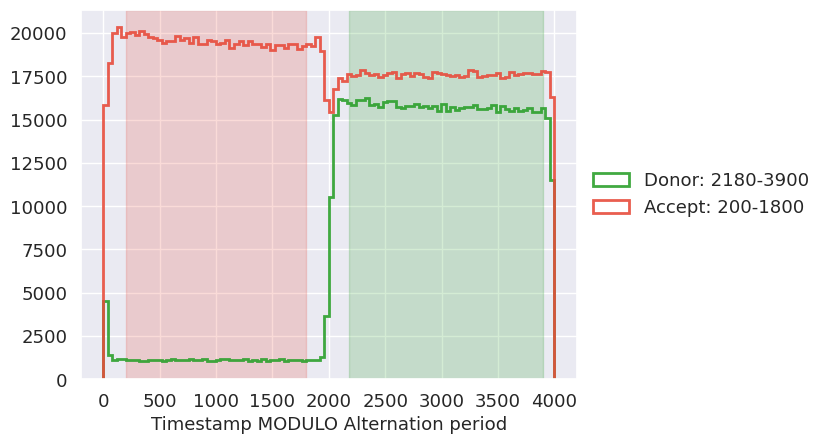

In [10]:
bpl.plot_alternation_hist(d)

If the previous alternation histogram looks correct, 
the corresponding definitions of the excitation periods can be applied to the data using the following command:

In [11]:
loader.alex_apply_period(d)

# Total photons (after ALEX selection):     2,259,522
#  D  photons in D+A excitation periods:      721,537
#  A  photons in D+A excitation periods:    1,537,985
# D+A photons in  D  excitation period:     1,434,842
# D+A photons in  A  excitation period:       824,680



If the previous histogram does not look right, the parameters in the `d.add(...)` cell can be modified and checked by running the histogram plot cell until everything looks fine. Don't forget to apply the 
parameters with `loader.usalex_apply_period(d)` as a last step.

> **NOTE:** After applying the ALEX parameters a new array of 
> timestamps containing only photons inside the excitation periods 
> is created (name `d.ph_times_m`). To save memory, by default, 
> the old timestamps array (`d.ph_times_t`) is deleted. Therefore, 
> in the following, when we talk about all-photon selection we always 
> refer to all photons inside both excitation periods.

# Background and burst search

In [12]:
d.calc_bg(bg.exp_fit, time_s=30, tail_min_us='auto', F_bg=1.7)

 - Calculating BG rates ... Channel 0
[DONE]


In [13]:
d.burst_search(L=10, m=10, F=6)

 - Performing burst search (verbose=False) ...[DONE]
 - Calculating burst periods ...[DONE]
 - Counting D and A ph and calculating FRET ... 
   - Applying background correction.
   [DONE Counting D/A]


First we filter the bursts to avoid creating big files:

In [14]:
ds = d.select_bursts(select_bursts.size, th1=60)

# Exporting Burst Data

By burst-data we mean all the scalar burst parameters, e.g. size, duration, background, etc...

We can easily get a table (a pandas DataFrame) with all the burst data as follows:

In [15]:
bursts = bext.burst_data(ds, include_bg=True, include_ph_index=True)
bursts.head(5)  # display first 5 bursts

,size_raw,t_start,t_stop,i_start,i_stop,bg_period,width_ms,bg_ad,bg_dd,bg_aa,bg_da,E,S,nd,na,nt,nda,naa,spot
0,147,1.732456,1.735530,5276,5422,0,3.074012,2.993976,1.795806,1.738086,0.249776,0.324223,0.571004,54.204194,26.006024,140.472131,-0.249776,60.261914,0
1,213,1.792993,1.795878,5961,6173,0,2.884513,2.809410,1.685103,1.630940,0.234378,0.420886,0.648480,77.314897,56.190590,205.874547,0.765622,72.369060,0
2,230,2.023545,2.026337,6757,6986,0,2.791962,2.719270,1.631036,1.578611,0.226858,0.451800,0.467038,57.368964,47.280730,224.071083,-0.226858,119.421389,0
3,113,3.113880,3.116244,10403,10515,0,2.363913,2.302365,1.380973,1.336586,0.192077,0.166462,0.984595,88.619027,17.697635,107.980076,-0.192077,1.663414,0
4,78,3.129707,3.133044,10548,10625,0,3.337650,3.250750,1.949821,1.887150,0.271197,0.137702,0.998409,61.050179,9.749250,70.912280,-0.271197,0.112850,0


Once we have the DataFrame, saving it to disk in CSV format is trivial:

In [16]:
bursts.to_csv('%s_burst_data.csv' % filename.replace('.hdf5', ''))

# Exporting Bursts Timestamps

A convenient way to deal with timestamps (and nanotimes if available) 
of photons inside bursts is exporting them as a DataFrame.
The function `bext.burst_photons` ([documentation](http://fretbursts.readthedocs.io/en/latest/plugins.html#fretbursts.burstlib_ext.burst_photons)) 
will export this "photon data"
with one row per photon. The columns are `timestamp` and, if available,
`nanotime`.

In [17]:
burstph = bext.burst_photons(ds)
burstph.head()

/home/paul/anaconda3/envs/Py38/lib/python3.8/site-packages/fretbursts/burstlib_ext.py:436: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  times_arr = np.hstack(
/home/paul/anaconda3/envs/Py38/lib/python3.8/site-packages/fretbursts/burstlib_ext.py:438: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  stream_arr = np.hstack(


timestamp  stream
burst ph                   
0     0   138596500  AexAem
      1   138622303  DexDem
      2   138626950  DexDem
      3   138641792  AexAem
      4   138643022  DexDem

This DataFrame has a two-level index (the first two columns): one is 
the burst number and the other is the photon number within each burst.
The photon number starts at 0 for the first photon of each burst.

As with any DataFrame, saving to disk is trivial:

In [18]:
burstph.to_csv('photon_data.csv')

To read the data back use:

In [19]:
import pandas as pd

In [20]:
burstph2 = pd.read_csv('photon_data.csv', index_col=(0, 1))
burstph2.head()

timestamp  stream
burst ph                   
0     0   138596500  AexAem
      1   138622303  DexDem
      2   138626950  DexDem
      3   138641792  AexAem
      4   138643022  DexDem

Verify the data we read is the same:

In [21]:
(burstph2 == burstph).all()

timestamp    True
stream       True
dtype: bool

## Using the timestamps DataFrame

Operations on the photon-data DataFrame are very simple.

### Transform the timestamps

An example of a transformation is rescaling to get timestamps in seconds:

In [22]:
burstph['times_s'] = burstph.timestamp * d.clk_p
burstph.head()

timestamp  stream   times_s
burst ph                             
0     0   138596500  AexAem  1.732456
      1   138622303  DexDem  1.732779
      2   138626950  DexDem  1.732837
      3   138641792  AexAem  1.733022
      4   138643022  DexDem  1.733038

### Compute burst-wise quantities

We can compute burst-wise quantities in one step without looping 
using standard [pandas group-by/apply](https://pandas.pydata.org/pandas-docs/stable/groupby.html) operations.

To do that, we group rows (photons) by `'burst'` and compute an arbitrary
function on each burst (for example the mean time):

In [23]:
burstph.groupby('burst')['times_s'].mean()

burst
0        1.734081
1        1.794125
2        2.025197
3        3.115339
4        3.131453
          ...    
983    597.336390
984    597.537687
985    598.285494
986    598.396130
987    598.865273
Name: times_s, Length: 988, dtype: float64

# Another example of exporting bursts timestamps

> **NOTE**: This section is provided as an example. Exporting timestamps in this way
> is not recommended. Use the approach in the previous section instead.
> The example here is an old example reported for educational purposes only.

Exporting timestamps and other photon-data for each bursts is a little trickier
because the data is less uniform (i.e. each burst has a different number of photons).
In the following example, we will save a `csv` file with variable-length columns.
Each burst is represented by to lines: one line for timestamps and one line for the
photon-stream (excitation/emission period) the timestamps belongs to.

Let's start by creating an array of photon streams containing
one of the values 0, 1, 2 or  3  for each timestamp.
These values will correspond to the DexDem, DexAem, AexDem, AemAem
photon streams respectively.

In [24]:
ds.A_ex

[array([False,  True,  True, ..., False,  True, False])]

In [25]:
#{0: DexDem, 1:DexAem, 2: AexDem, 3: AemAem}

In [26]:
(ds.A_ex[0].view('int8') << 1) + ds.A_em[0].view('int8')

array([1, 3, 3, ..., 1, 3, 0], dtype=int8)

Now we define an header documenting the file format. We will also include the 
filename of the measurement. 

This is just an example including nanotimes:

In [27]:
header = """\
# BPH2CSV: %s
# Lines per burst: 3
# - timestamps (int64): in 12.5 ns units
# - nanotimes (int16): in raw TCSPC unit (3.3ps)
# - stream (uint8): the photon stream according to the mapping {0: DexDem, 1: DexAem, 2: AexDem, 3: AemAem}
""" % filename
print(header)

# BPH2CSV: ./data/0023uLRpitc_NTP_20dT_0.5GndCl.hdf5
# Lines per burst: 3
# - timestamps (int64): in 12.5 ns units
# - nanotimes (int16): in raw TCSPC unit (3.3ps)
# - stream (uint8): the photon stream according to the mapping {0: DexDem, 1: DexAem, 2: AexDem, 3: AemAem}



And this is header we are going to use:

In [28]:
header = """\
# BPH2CSV: %s
# Lines per burst: 2
# - timestamps (int64): in 12.5 ns units
# - stream (uint8): the photon stream according to the mapping {0: DexDem, 1: DexAem, 2: AexDem, 3: AemAem}
""" % filename
print(header)

# BPH2CSV: ./data/0023uLRpitc_NTP_20dT_0.5GndCl.hdf5
# Lines per burst: 2
# - timestamps (int64): in 12.5 ns units
# - stream (uint8): the photon stream according to the mapping {0: DexDem, 1: DexAem, 2: AexDem, 3: AemAem}



We can now save the data to disk:

In [29]:
out_fname = '%s_burst_timestamps.csv' % filename.replace('.hdf5', '')
dx = ds
ich = 0

bursts = dx.mburst[ich]
timestamps = dx.ph_times_m[ich]
stream = (dx.A_ex[ich].view('int8') << 1) + dx.A_em[ich].view('int8')
with open(out_fname, 'wt') as f:
    f.write(header)
    for times, period in zip(bl.iter_bursts_ph(timestamps, bursts),
                             bl.iter_bursts_ph(stream, bursts)):
        times.tofile(f, sep=',')
        f.write('\n')
        period.tofile(f, sep=',')
        f.write('\n')

## Read the file back

For consistency check, we can read back the data we just saved.
As an exercise we will put the results in a pandas DataFrame
which is more convenient than an array for holding this data.

In [30]:
import pandas as pd

We start reading the header and computing 
some file-specific constants. 

In [31]:
with open(out_fname) as f:
    lines = []
    lines.append(f.readline())
    while lines[-1].startswith('#'):
        lines.append(f.readline())
    header = ''.join(lines[:-1])
print(header)

# BPH2CSV: ./data/0023uLRpitc_NTP_20dT_0.5GndCl.hdf5
# Lines per burst: 2
# - timestamps (int64): in 12.5 ns units
# - stream (uint8): the photon stream according to the mapping {0: DexDem, 1: DexAem, 2: AexDem, 3: AemAem}



In [32]:
stream_map = {0: 'DexDem', 1: 'DexAem', 2: 'AexDem', 3: 'AemAem'}
nrows = int(header.split('\n')[1].split(':')[1].strip())
header_len = len(header.split('\n')) - 1
header_len, nrows

(4, 2)

As a test, we load the data for the first burst into a dataframe, converting the numerical column "streams"
into photon-stream names (strings). The new column is of type categorical, so it will take very little space:

In [33]:
burstph = (pd.read_csv(out_fname, skiprows=header_len, nrows=nrows, header=None).T
           .rename(columns={0: 'timestamp', 1: 'stream'}))
StreamCategorical = pd.api.types.CategoricalDtype(categories=['DexDem', 'DexAem', 'AexDem', 'AemAem'], ordered=True)
burstph.stream = (burstph.stream
                  .apply(lambda x: stream_map[pd.to_numeric(x)])
                  .astype(StreamCategorical))
burstph

,timestamp,stream
0,138596500,AemAem
1,138622303,DexDem
2,138626950,DexDem
3,138641792,AemAem
4,138643022,DexDem
...,...,...
142,138788833,AemAem
143,138790337,DexDem
144,138790703,DexAem
145,138790873,DexAem


For reading the whole file I use a different approach. First, I load the entire file 
in two lists of lists (one for timestamps and one for the stream). Next, I create
a single DataFrame with a third column indicating the burst index.

In [34]:
import csv
from builtins import int  # python 2 workaround, can be removed on python 3

# Read data in two list of lists
t_list, s_list = [], []
with open(out_fname) as f:
    for i in range(header_len):
        f.readline()
    csvreader = csv.reader(f)    
    for row in csvreader:
        t_list.append([int(v) for v in row])
        s_list.append([int(v) for v in next(csvreader)])

# Turn the inner list into pandas.DataFrame
d_list = []
for ib, (t, s) in enumerate(zip(t_list, s_list)):
    d_list.append(
        pd.DataFrame({'timestamp': t, 'stream': s}, columns=['timestamp', 'stream'])
        .assign(iburst=ib)
    )

# Concatenate dataframes
burstph = pd.concat(d_list, ignore_index=True)

# Convert stream column into categorical
StreamCategorical = pd.api.types.CategoricalDtype(categories=['DexDem', 'DexAem', 'AexDem', 'AemAem'], ordered=True)
burstph.stream = (burstph.stream
                  .apply(lambda x: stream_map[pd.to_numeric(x)])
                  .astype(StreamCategorical))
burstph

,timestamp,stream,iburst
0,138596500,AemAem,0
1,138622303,DexDem,0
2,138626950,DexDem,0
3,138641792,AemAem,0
4,138643022,DexDem,0
...,...,...,...
232327,47909435404,DexAem,987
232328,47909438825,DexAem,987
232329,47909451409,DexDem,987
232330,47909458878,DexAem,987


In [35]:
burstph.dtypes

timestamp       int64
stream       category
iburst          int64
dtype: object

This was just an example. There are certainly more efficient ways 
to read the file into a DataFrame. Please feel free to contribute
new methods to illustrate a different (more efficient or simpler)
approach.